In [2]:
# Set up plotting options
%matplotlib inline

In [3]:
# need to run and restart instance
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install segmentation-models-pytorch

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-i3ajs6u3
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-i3ajs6u3
  Resolved https://github.com/albu/albumentations to commit c9cb7720132c1261db562bf6b5fd967acff5dc8c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
# load packages
import os
import sys
import cv2
import gdown
import numpy as np
import pandas as pd
from glob import glob
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

import torch
from torch.utils.data import Dataset, DataLoader

# Download dataset

In [5]:
# check if files are already downloaded
dset_download = os.path.isdir('/content/ETCI_2021_Competition_Dataset/train/')

if dset_download is False:
  url = 'https://drive.google.com/uc?id=14HqNW5uWLS92n7KrxKgDwUTsSEST6LCr'
  output = 'train.tgz'
  gdown.download(url, output, quiet=False)

  url = 'https://drive.google.com/uc?id=1GWl3g1G152Rinxc1Fbc-JkSWlRQNWKBK'
  output = 'valid.tgz'
  gdown.download(url, output, quiet=False)

### Move and unzip files

In [6]:
if dset_download is False:
  !mkdir -p /content/ETCI_2021_Competition_Dataset

  !mv /content/train.tgz /content/ETCI_2021_Competition_Dataset/
  !mv /content/valid.tgz /content/ETCI_2021_Competition_Dataset/

  !unzip -q /content/ETCI_2021_Competition_Dataset/train.tgz -d /content/ETCI_2021_Competition_Dataset
  !unzip -q /content/ETCI_2021_Competition_Dataset/valid.tgz -d /content/ETCI_2021_Competition_Dataset

# Set path to where dataset is downloaded

In [7]:
# path to dataset root directory
dset_root = '/content/ETCI_2021_Competition_Dataset/'

In [8]:
print(os.listdir(dset_root))

['train.tgz', 'train', 'val', '__MACOSX', 'valid.tgz']


In [9]:
# get number of training/validation regions
train_dir = os.path.join(dset_root, 'train')
val_dir = os.path.join(dset_root, 'val')

n_train_regions = len(glob(train_dir+'/*/'))
n_valid_regions = len(glob(val_dir+'/*/'))

# NOTE: make sure number of regions is NOT 0
print('Number of training temporal-regions: {}'.format(n_train_regions))
print('Number of validation temporal-regions: {}'.format(n_valid_regions))

Number of training temporal-regions: 31
Number of validation temporal-regions: 10


In [10]:
glob(train_dir+'/northal_20190513t234653/tiles/**')

['/content/ETCI_2021_Competition_Dataset/train/northal_20190513t234653/tiles/flood_label',
 '/content/ETCI_2021_Competition_Dataset/train/northal_20190513t234653/tiles/water_body_label',
 '/content/ETCI_2021_Competition_Dataset/train/northal_20190513t234653/tiles/vv',
 '/content/ETCI_2021_Competition_Dataset/train/northal_20190513t234653/tiles/vh']

# Create train and val df

In [11]:
def get_filename(filepath):
    return os.path.split(filepath)[1]


In [12]:
vv_image_paths = sorted(glob(train_dir+'/**/vv/*.png', recursive=True))
vv_image_names = [get_filename(pth) for pth in vv_image_paths]
region_name_dates = ['_'.join(n.split('_')[:2]) for n in vv_image_names]


vh_image_paths, flood_label_paths, water_body_label_paths, region_names = [], [], [], []
for i in range(len(vv_image_paths)):
    # get vh image path
    vh_image_name = vv_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

    # get flood mask path
    flood_image_name = vv_image_names[i].replace('_vv', '')
    flood_label_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'flood_label', flood_image_name)
    flood_label_paths.append(flood_label_path)

    # get water body mask path
    water_body_label_name = vv_image_names[i].replace('_vv', '')
    water_body_label_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths.append(water_body_label_path)

    # get region name
    region_name = region_name_dates[i].split('_')[0]
    region_names.append(region_name)


train_paths = {'vv_image_path': vv_image_paths,
        'vh_image_path': vh_image_paths,
        'flood_label_path': flood_label_paths,
        'water_body_label_path': water_body_label_paths,
        'region': region_names
}


train_df = pd.DataFrame(train_paths)

print(train_df.shape)
train_df.head()

(33405, 5)


vv_image_path  \
0  /content/ETCI_2021_Competition_Dataset/train/b...   
1  /content/ETCI_2021_Competition_Dataset/train/b...   
2  /content/ETCI_2021_Competition_Dataset/train/b...   
3  /content/ETCI_2021_Competition_Dataset/train/b...   
4  /content/ETCI_2021_Competition_Dataset/train/b...   

                                       vh_image_path  \
0  /content/ETCI_2021_Competition_Dataset/train/b...   
1  /content/ETCI_2021_Competition_Dataset/train/b...   
2  /content/ETCI_2021_Competition_Dataset/train/b...   
3  /content/ETCI_2021_Competition_Dataset/train/b...   
4  /content/ETCI_2021_Competition_Dataset/train/b...   

                                    flood_label_path  \
0  /content/ETCI_2021_Competition_Dataset/train/b...   
1  /content/ETCI_2021_Competition_Dataset/train/b...   
2  /content/ETCI_2021_Competition_Dataset/train/b...   
3  /content/ETCI_2021_Competition_Dataset/train/b...   
4  /content/ETCI_2021_Competition_Dataset/train/b...   

                               water_body_label_path      region  
0  /content/ETCI_2021_Competition_Dataset/train/b...  bangladesh  
1  /content/ETCI_2021_Competition_Dataset/train/b...  bangladesh  
2  /content/ETCI_2021_Competition_Dataset/train/b...  bangladesh  
3  /content/ETCI_2021_Competition_Dataset/train/b...  bangladesh  
4  /content/ETCI_2021_Competition_Dataset/train/b...  bangladesh

In [13]:
vv_image_paths = sorted(glob(val_dir+'/**/vv/*.png', recursive=True))
vv_image_names = [get_filename(pth) for pth in vv_image_paths]
region_name_dates = ['_'.join(n.split('_')[:2]) for n in vv_image_names]


vh_image_paths, flood_label_paths, water_body_label_paths, region_names = [], [], [], []
for i in range(len(vv_image_paths)):
    # get vh image path
    vh_image_name = vv_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(val_dir, region_name_dates[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

    # get flood mask path ()
    flood_label_paths.append(np.nan)

    # get water body mask path
    water_body_label_name = vv_image_names[i].replace('_vv', '')
    water_body_label_path = os.path.join(val_dir, region_name_dates[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths.append(water_body_label_path)

    # get region name
    region_name = region_name_dates[i].split('_')[0]
    region_names.append(region_name)

valid_paths = {'vv_image_path': vv_image_paths,
        'vh_image_path': vh_image_paths,
        'flood_label_path': flood_label_paths,
        'water_body_label_path': water_body_label_paths,
        'region': region_names
}


val_df = pd.DataFrame(valid_paths)
val_df.sort_values(by=['vv_image_path'])  # important line for submitting results

print(val_df.shape)
val_df.head()

(10400, 5)


vv_image_path  \
0  /content/ETCI_2021_Competition_Dataset/val/flo...   
1  /content/ETCI_2021_Competition_Dataset/val/flo...   
2  /content/ETCI_2021_Competition_Dataset/val/flo...   
3  /content/ETCI_2021_Competition_Dataset/val/flo...   
4  /content/ETCI_2021_Competition_Dataset/val/flo...   

                                       vh_image_path  flood_label_path  \
0  /content/ETCI_2021_Competition_Dataset/val/flo...               NaN   
1  /content/ETCI_2021_Competition_Dataset/val/flo...               NaN   
2  /content/ETCI_2021_Competition_Dataset/val/flo...               NaN   
3  /content/ETCI_2021_Competition_Dataset/val/flo...               NaN   
4  /content/ETCI_2021_Competition_Dataset/val/flo...               NaN   

                               water_body_label_path    region  
0  /content/ETCI_2021_Competition_Dataset/val/flo...  florence  
1  /content/ETCI_2021_Competition_Dataset/val/flo...  florence  
2  /content/ETCI_2021_Competition_Dataset/val/flo...  florence  
3  /content/ETCI_2021_Competition_Dataset/val/flo...  florence  
4  /content/ETCI_2021_Competition_Dataset/val/flo...  florence

# Visualize some images

In [14]:
def to_rgb(vv_image, vh_image):
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
  rgb_image = np.stack((vv_image, vh_image, 1-ratio_image), axis=2)
  return rgb_image

In [15]:
def visualize(df_row):
  # vv = df_row['vv_image_path']
  # vh = df_row['vh_image_path']
  # water_body_label = df_row['water_body_label_path']
  # flood_label = df_row['flood_label_path']

  # vv = cv2.imread(vv, 0) / 255.0
  # vh = cv2.imread(vh, 0) / 255.0
  # water_body_label = cv2.imread(water_body_label, 0) / 255.0
  # flood_label = cv2.imread(flood_label, 0) / 255.0

  # ratio_image = np.clip(np.nan_to_num(vv/vh, 0), 0, 1)
  # rgb_image = np.stack((vh, vv, 1-ratio_image), axis=2)

  # print("Shape of RGB:", rgb_image.shape)
  # print("Shape of Water Body:", water_body_label.shape)
  # print("Shape of Flood:", flood_label.shape)

  # fig, ax = plt.subplots(1,3, figsize=(15,5))
  # ax[0].imshow(vv)
  # ax[0].set_title('rgb_image')
  # ax[1].imshow(water_body_label)#, cmap='gray')
  # ax[1].set_title('water_body_label')
  # ax[2].imshow(flood_label)
  # ax[2].set_title('flood_label')

  # plt.tight_layout()  # Adjust subplot parameters for a tight layout
  # plt.show()

  # get image paths
    vv_image_path = df_row['vv_image_path']
    vh_image_path = df_row['vh_image_path']
    flood_label_path = df_row['flood_label_path']
    water_body_label_path = df_row['water_body_label_path']

    # create RGB image from S1 images
    rgb_name = get_filename(vv_image_path).replace('_vv.png', '')
    vv_image = cv2.imread(vv_image_path, 0) / 255.0
    vh_image = cv2.imread(vh_image_path, 0) / 255.0
    rgb_image = to_rgb(vv_image, vh_image)

    # get flood label mask

    # get water body label mask
    water_body_label_image = cv2.imread(water_body_label_path, 0) / 255.0

    # plot images
    plt.figure(figsize=(15,5))
    if df_row.isnull().sum() > 0:
        # plot RGB S1 image
        plt.subplot(1,2,1)
        plt.imshow(rgb_image)
        plt.title(rgb_name)

        # plot water body mask
        plt.subplot(1,2,2)
        plt.imshow(water_body_label_image)
        plt.title('Water body mask')
    else:
        flood_label_image = cv2.imread(flood_label_path, 0) / 255.0

        # plot RGB S1 image
        plt.subplot(1,3,1)
        plt.imshow(rgb_image)
        plt.title(rgb_name)

        # plot flood label mask
        plt.subplot(1,3,2)
        plt.imshow(flood_label_image)
        plt.title('Flood mask')

        # plot water body mask
        plt.subplot(1,3,3)
        plt.imshow(water_body_label_image)
        plt.title('Water body mask')


In [16]:
train_df.iloc[16601]['vh_image_path'],train_df.iloc[16601]['vv_image_path'], train_df.iloc[16601]['water_body_label_path'], train_df.iloc[16601]['flood_label_path']

('/content/ETCI_2021_Competition_Dataset/train/nebraska_20171210t002119/tiles/vh/nebraska_20171210t002119_x-13_y-28_vh.png',
 '/content/ETCI_2021_Competition_Dataset/train/nebraska_20171210t002119/tiles/vv/nebraska_20171210t002119_x-13_y-28_vv.png',
 '/content/ETCI_2021_Competition_Dataset/train/nebraska_20171210t002119/tiles/water_body_label/nebraska_20171210t002119_x-13_y-28.png',
 '/content/ETCI_2021_Competition_Dataset/train/nebraska_20171210t002119/tiles/flood_label/nebraska_20171210t002119_x-13_y-28.png')

In [17]:
val_df.iloc[100]['vh_image_path'],val_df.iloc[100]['vv_image_path'], val_df.iloc[100]['water_body_label_path'], val_df.iloc[100]['flood_label_path']

('/content/ETCI_2021_Competition_Dataset/val/florence_20180510t231343/tiles/vh/florence_20180510t231343_x-11_y-28_vh.png',
 '/content/ETCI_2021_Competition_Dataset/val/florence_20180510t231343/tiles/vv/florence_20180510t231343_x-11_y-28_vv.png',
 '/content/ETCI_2021_Competition_Dataset/val/florence_20180510t231343/tiles/water_body_label/florence_20180510t231343_x-11_y-28.png',
 np.float64(nan))

<ipython-input-14-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-14-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)


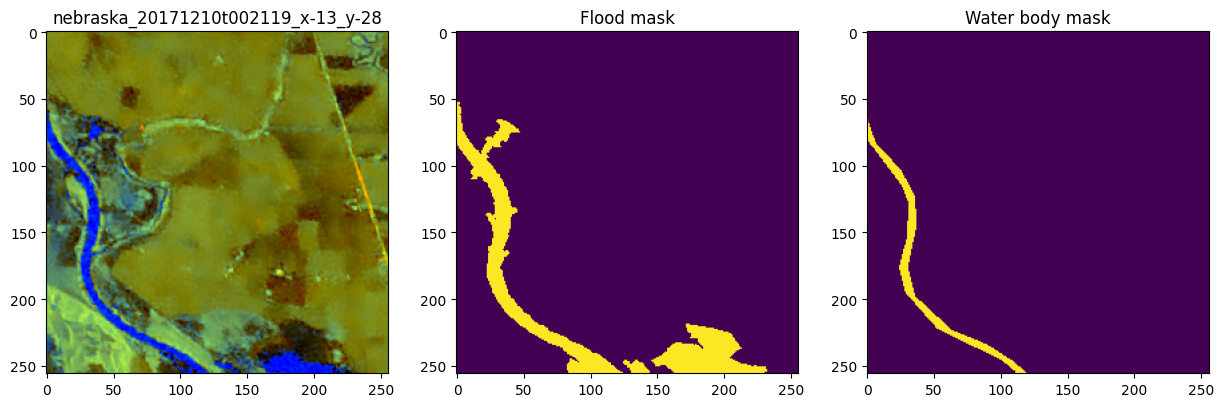

In [18]:
visualize(train_df.iloc[16601])

<ipython-input-14-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)


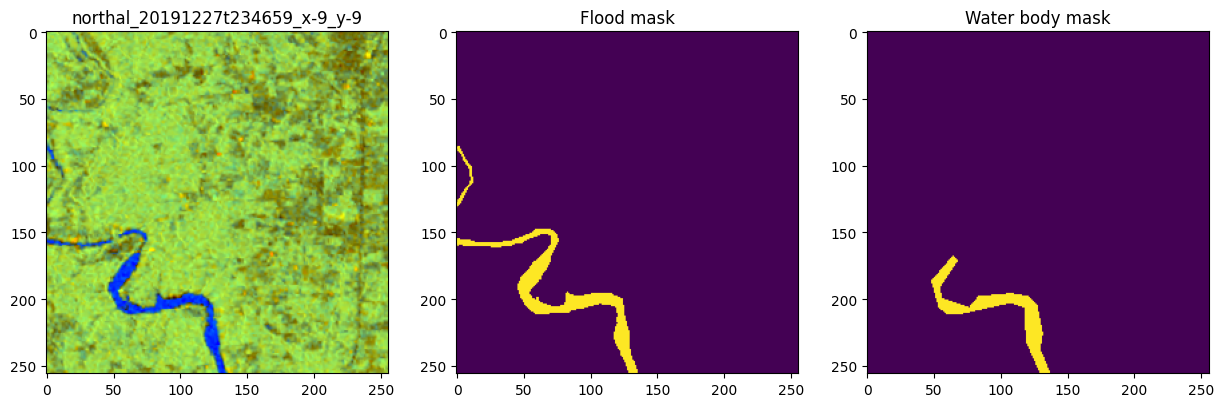

In [19]:
visualize(train_df.iloc[-1])

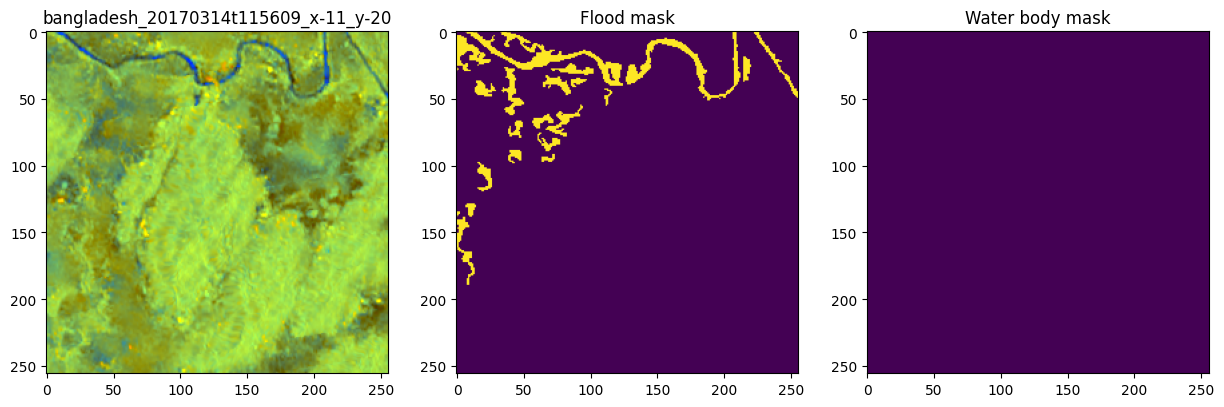

In [20]:
visualize(train_df.iloc[100])

<ipython-input-14-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-14-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)


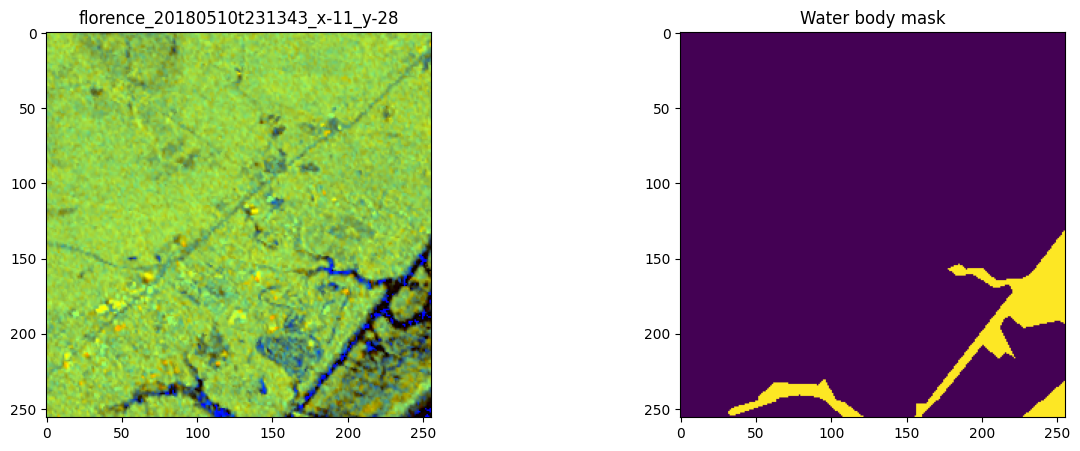

In [21]:
visualize(val_df.iloc[100])

In [22]:
# all regions in the training set
regions = ['nebraska', 'northal', 'bangladesh']

# randomly choose one for the development set and leave the rest for training
development_region = np.random.choice(regions, 1)[0]
regions.remove(development_region)
train_regions = regions

# filter the dataframe to only get images from specified regions
sub_train_df = train_df[train_df['region'] != development_region]
development_df = train_df[train_df['region'] == development_region]

# check that new dataframes only have the image paths from the correct regions
print('Sub-training set regions: {}'.format(np.unique(sub_train_df['region'].tolist())))
print('Development set region: {}'.format(np.unique(development_df['region'].tolist())))

Sub-training set regions: ['bangladesh' 'nebraska']
Development set region: ['northal']


# Preparing data for ML

In [23]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.2),
    # A.Affine(scale=(0.8, 1.2), translate_percent=(0, 0.1), rotate=(-45, 45), shear=(-10, 10), p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.2),
    # A.OpticalDistortion(p=0.3),
    # A.GridDistortion(p=.1),
    # A.HueSaturationValue(p=0.3),
    # A.CLAHE(p=0.3),
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

])

In [24]:
class SARdataset(Dataset):
  def __init__(self, df, split, transform=None):
    self.df = df
    self.split= split
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    df_row = self.df.iloc[index]

    vv_image = cv2.imread(df_row['vv_image_path'], 0) / 255.0
    vh_image = cv2.imread(df_row['vh_image_path'], 0) / 255.0

    rgb_image = to_rgb(vv_image, vh_image)

    image_set = {}
    if self.split == 'test':
      image_set['image'] = rgb_image.transpose((2,0,1)).astype('float32')
      #only image
    else:
      flood_mask = cv2.imread(df_row['flood_label_path'], 0) / 255.0

      if self.transform:
        augmented = self.transform(image=rgb_image, mask=flood_mask)
        rgb_image = augmented['image']
        flood_mask = augmented['mask']

      image_set['image'] = rgb_image.transpose((2,0,1)).astype('float32')
      image_set['mask'] = flood_mask.astype('int64')


    # flood_mask = cv2.imread(df_row['flood_label_path'], 0) / 255.0 if self.split == 'train' else np.zeros_like(rgb_image[:,:,0])

    return image_set


In [25]:
train_dataset  = SARdataset(sub_train_df, split='train', transform=transform)
dev_dataset = SARdataset(development_df, split='dev')

In [26]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
dev_loader = DataLoader(dev_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# DL Model

## (M) model

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [29]:
import torchvision.models.segmentation as models
import segmentation_models_pytorch as smp

In [30]:
def get_model(num_classes=2):#, weights=models.DeepLabV3_ResNet50_Weights.DEFAULT):
  # model = models.deeplabv3_resnet50(weights=weights)#encoder_weights='imagenet', classes=2)

  # model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)

  model = smp.Unet(
      encoder_name="timm-efficientnet-b0",  # Specify the EfficientNetV2 backbone
      encoder_weights="imagenet",     # Use pre-trained weights
      in_channels=3,                  # Input image channels (RGB)
      classes=2,                      # Number of output classes (flood/no-flood)
  )


  return model


In [31]:
model = get_model(num_classes=2)
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Unet(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Swish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Swish()
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), 

## (O) optimizer

In [32]:

import torch.optim as optim
from torch.optim import lr_scheduler

optimizer = optim.AdamW(model.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7,gamma=0.1)

## (L) Loss function

In [33]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()

## (T) Training

### function to calculate iou score

In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
def iou_score(preds, targets, num_classes=2):
    preds = torch.argmax(preds, dim=1)
    preds = preds.flatten().cpu().numpy()
    targets = targets.flatten().cpu().numpy()

    # If there's no positive class in ground truth, skip this sample
    if np.sum(targets == 1) == 0:
        return None  # skip IoU computation

    cm = confusion_matrix(targets, preds, labels=list(range(num_classes)))

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        iou = tp / (tp + fp + fn + 1e-6)
    else:
        iou = 0

    return iou



In [70]:
num_epochs = 5
# best_iou = 0.0

for epoch in range(num_epochs):
    if device == 'cuda':
        torch.cuda.empty_cache()

    # ===== TRAINING =====
    model.train()
    train_loss = 0.0
    train_iou = 0.0
    count = 0

    pbar_train = tqdm(train_loader, desc=f"[Train Epoch {epoch+1}]")
    for batch in pbar_train:

       # load images and mask to device
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        #set up the NN
        optimizer.zero_grad()
        outputs = model(images)#['out'] #forward pass
        loss = criterion(outputs, masks)
        loss.backward() #backward pass
        optimizer.step()

        train_loss += loss.item()
        batch_iou = iou_score(outputs, masks)

        if batch_iou is not None:
            train_iou += batch_iou
            count += 1

        # update tqdm bar
        pbar_train.set_postfix(loss=loss.item(), iou=train_iou / (pbar_train.n + 1))

    train_loss /= max(count, 1)
    train_iou /= len(train_loader)

    #step scheduler after training epoch
    scheduler.step()

    # ===== VALIDATION =====
    model.eval()
    dev_loss = 0.0
    dev_iou = 0.0
    count = 0

    pbar_val = tqdm(dev_loader, desc=f"[Val Epoch {epoch+1}]")
    with torch.no_grad():
        for batch in pbar_val:

            images = batch['image'].to(device)
            masks = batch['mask'].to(device)

            outputs = model(images)#['out']

            loss = criterion(outputs, masks)

            batch_iou = iou_score(outputs, masks)

            if batch_iou is not None:
                dev_iou += batch_iou
                count += 1

            dev_loss += loss.item()

            # update tqdm bar
            pbar_val.set_postfix(loss=loss.item(), iou=dev_iou / (pbar_val.n + 1))

            # if dev_iou > best_iou:
            #   best_iou = dev_iou
            #   torch.save(model.state_dict(), 'best_model.pth')
            #   print(f" Saved best model at epoch {epoch+1} with IoU {best_iou:.4f}")

    dev_loss /= len(dev_loader)
    dev_iou /= max(count, 1)  # avoid division by zero


    print(f"\nEpoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f} | "
          f"Val Loss: {dev_loss:.4f}, Val IoU: {dev_iou:.4f}\n")


[Train Epoch 1]:   0%|          | 0/1701 [00:00<?, ?it/s]

<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)


[Val Epoch 1]:   0%|          | 0/388 [00:00<?, ?it/s]

<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)



Epoch [1/5] Train Loss: 0.0314, Train IoU: 0.5835 | Val Loss: 0.4970, Val IoU: 0.1238



[Train Epoch 2]:   0%|          | 0/1701 [00:00<?, ?it/s]

<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)


[Val Epoch 2]:   0%|          | 0/388 [00:00<?, ?it/s]

<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)



Epoch [2/5] Train Loss: 0.0314, Train IoU: 0.5804 | Val Loss: 0.4883, Val IoU: 0.1381



[Train Epoch 3]:   0%|          | 0/1701 [00:00<?, ?it/s]

<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)


[Val Epoch 3]:   0%|          | 0/388 [00:00<?, ?it/s]

<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)



Epoch [3/5] Train Loss: 0.0312, Train IoU: 0.5835 | Val Loss: 0.4564, Val IoU: 0.1258



[Train Epoch 4]:   0%|          | 0/1701 [00:00<?, ?it/s]

<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)


[Val Epoch 4]:   0%|          | 0/388 [00:00<?, ?it/s]

<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)



Epoch [4/5] Train Loss: 0.0313, Train IoU: 0.5821 | Val Loss: 0.6099, Val IoU: 0.1474



[Train Epoch 5]:   0%|          | 0/1701 [00:00<?, ?it/s]

<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)


[Val Epoch 5]:   0%|          | 0/388 [00:00<?, ?it/s]

<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-13-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)



Epoch [5/5] Train Loss: 0.0314, Train IoU: 0.5858 | Val Loss: 0.5443, Val IoU: 0.1350



In [71]:
# save model
torch.save(model.state_dict(), 'model.pt')

In [72]:
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your saved model in Google Drive
model_path = '/content/drive/My Drive/model.pt' # Replace with the actual path

torch.save(model.state_dict(), model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Model

In [73]:
model = get_model()
model.load_state_dict(torch.load('model.pt'))
model.to(device)
model.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Swish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Swish()
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), 

In [36]:
model = get_model()
# Define the path to your saved model in Google Drive
model_path = '/content/drive/My Drive/model.pt' # Replace with the actual path

# Load the saved state dictionary
model.load_state_dict(torch.load(model_path))
model.to(device)


Unet(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Swish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Swish()
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), 

# Test Model

In [37]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

])

In [38]:
test_dataset = SARdataset(val_df, split='test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

In [39]:
def visualize_result(df_row, prediction, figsize=[25, 15]):
    vv_image = cv2.imread(df_row['vv_image_path'], 0) / 255.0
    vh_image = cv2.imread(df_row['vh_image_path'], 0) / 255.0
    rgb_input = to_rgb(vv_image, vh_image)

    plt.figure(figsize=tuple(figsize))
    plt.subplot(1,2,1)
    plt.imshow(rgb_input)
    plt.title('RGB w/ result')
    plt.subplot(1,2,2)
    plt.imshow(prediction)
    plt.title('Result')

In [40]:
final_predictions = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        # load image and mask into device memory
        image = batch['image'].to(device)
        pred = model(image)
        output_tensor = pred#['out']

        # compute class predictions, i.e. flood or no-flood
        class_pred = output_tensor.argmax(dim=1)

        # convert class prediction to numpy
        class_pred = class_pred.detach().cpu().numpy()

        # add to final predictions
        final_predictions.append(class_pred.astype('uint8'))

final_predictions = np.concatenate(final_predictions, axis=0)

# check final prediction shape
print(final_predictions.shape)

  0%|          | 0/650 [00:00<?, ?it/s]

<ipython-input-14-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-14-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-14-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-14-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)


(10400, 256, 256)


<ipython-input-14-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-14-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)


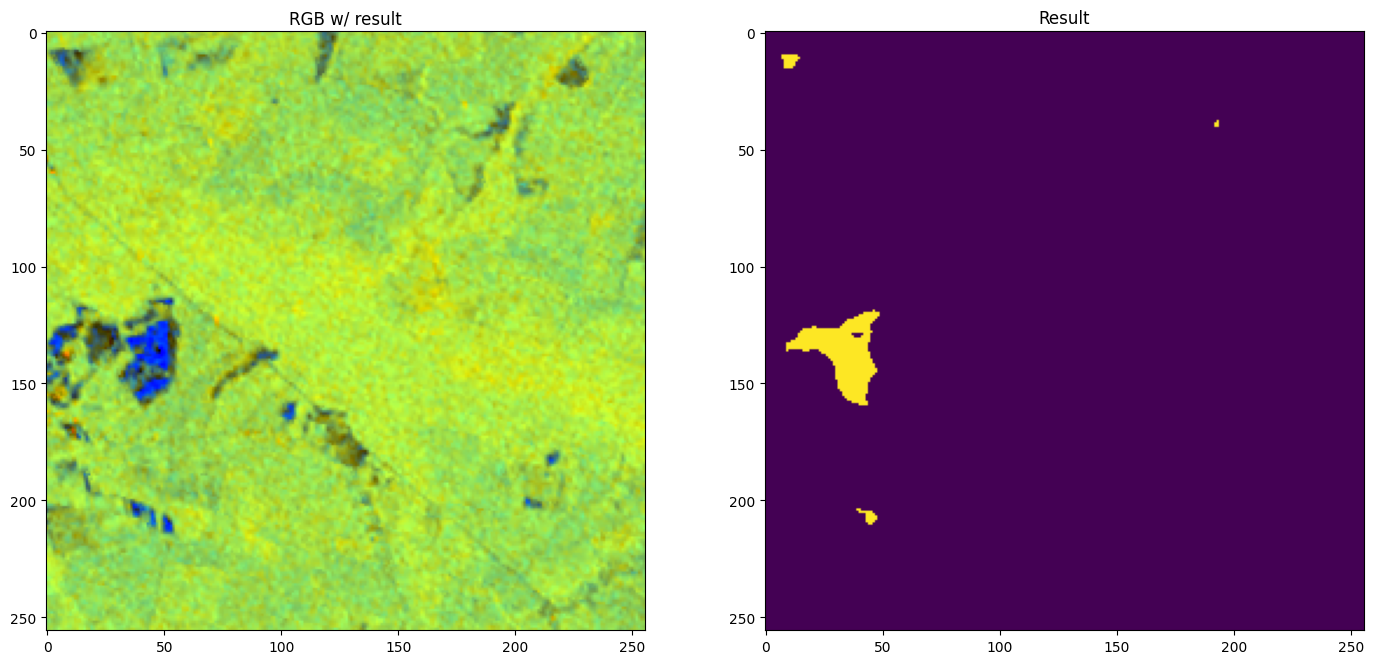

In [41]:
index = -1910
visualize_result(val_df.iloc[index], final_predictions[index], figsize=(17,10))

In [ ]:
index = 570
visualize_result(valid_df.iloc[index], final_predictions[index], figsize=(17,10))

<ipython-input-14-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)


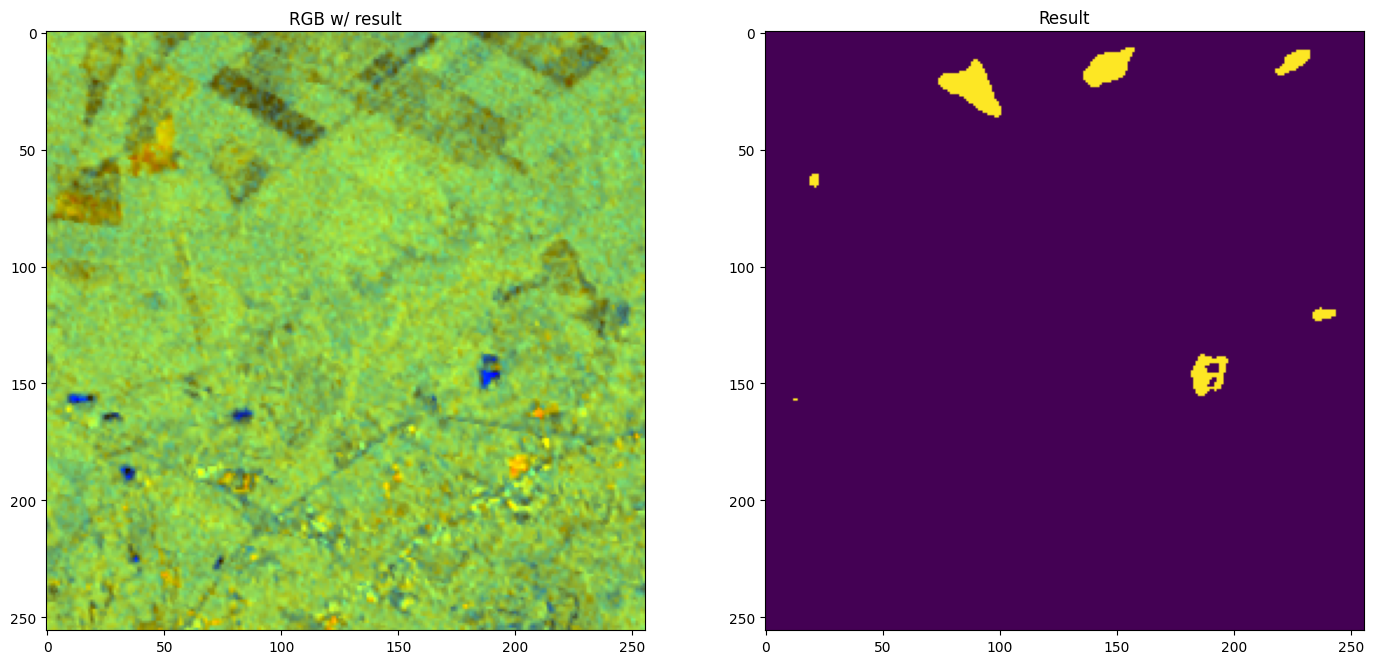

In [42]:
index = 68
visualize_result(val_df.iloc[index], final_predictions[index], figsize=(17,10))

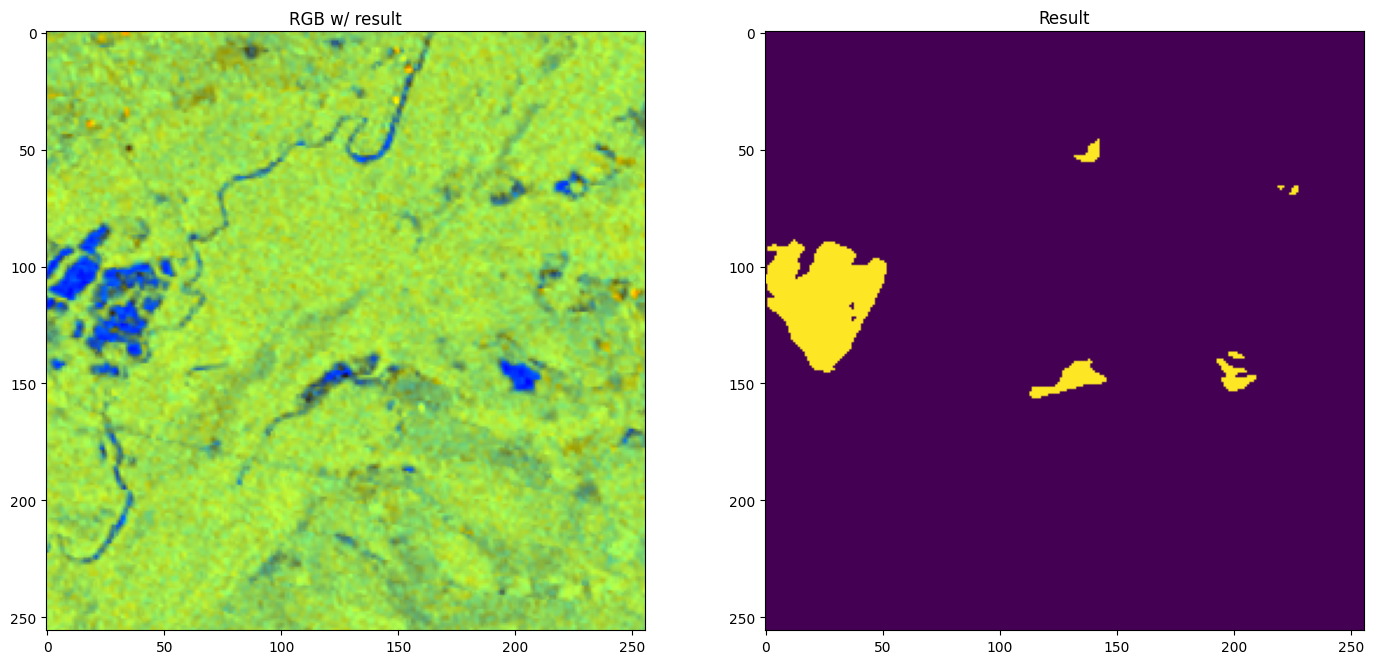

In [45]:
index = -1919
visualize_result(val_df.iloc[index], final_predictions[index], figsize=(17,10))

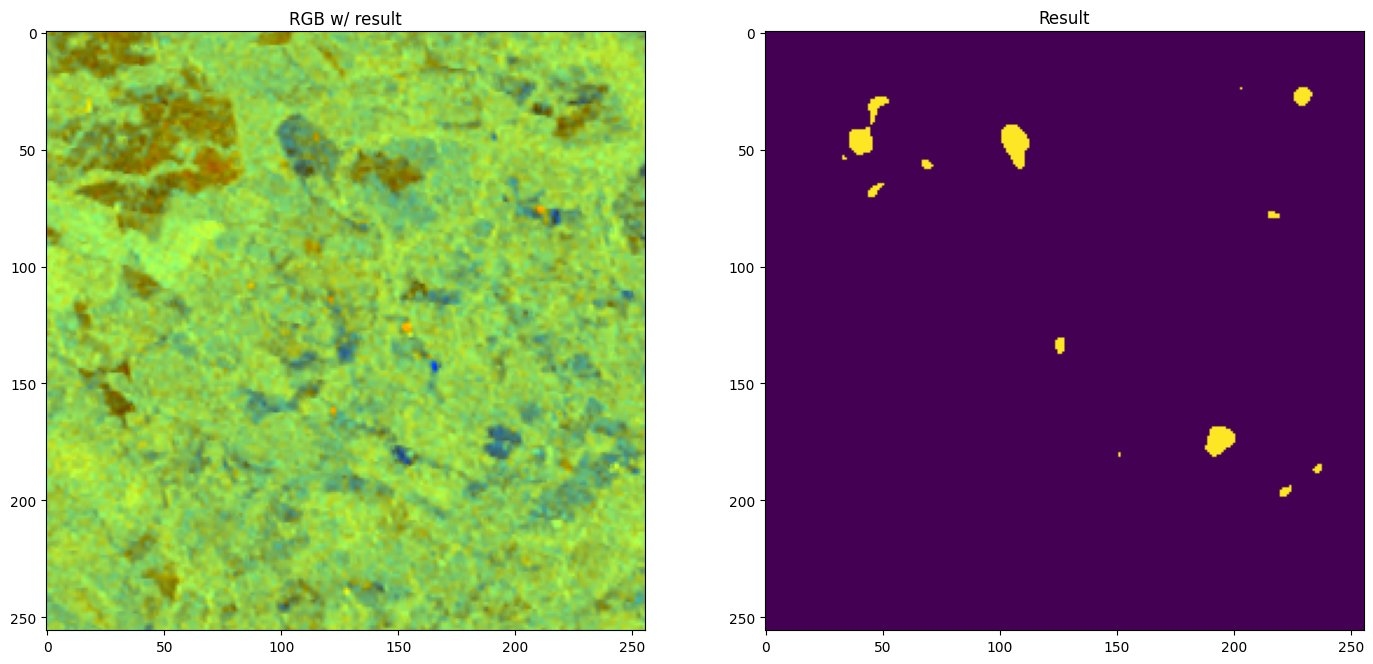

In [47]:
index = -1
visualize_result(val_df.iloc[index], final_predictions[index], figsize=(17,10))

<ipython-input-14-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-14-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)


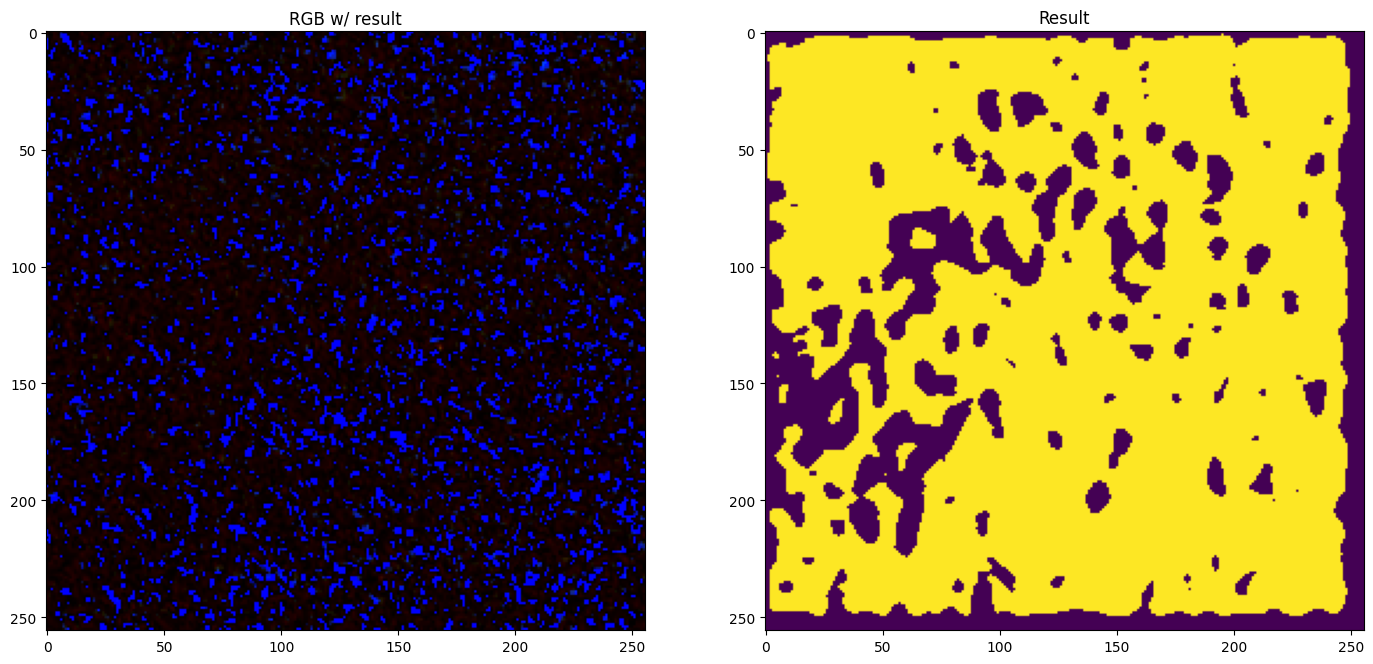

In [49]:
index = 498
visualize_result(val_df.iloc[index], final_predictions[index], figsize=(17,10))

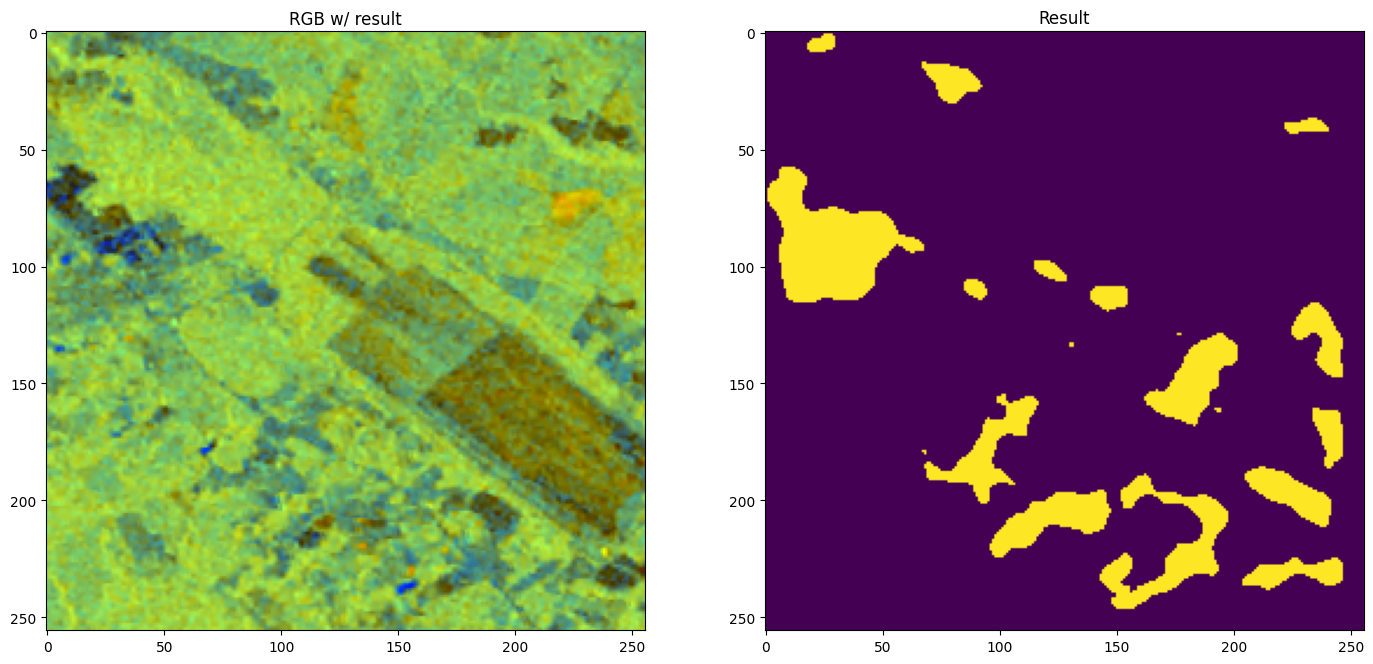

In [50]:
index = 75
visualize_result(val_df.iloc[index], final_predictions[index], figsize=(17,10))

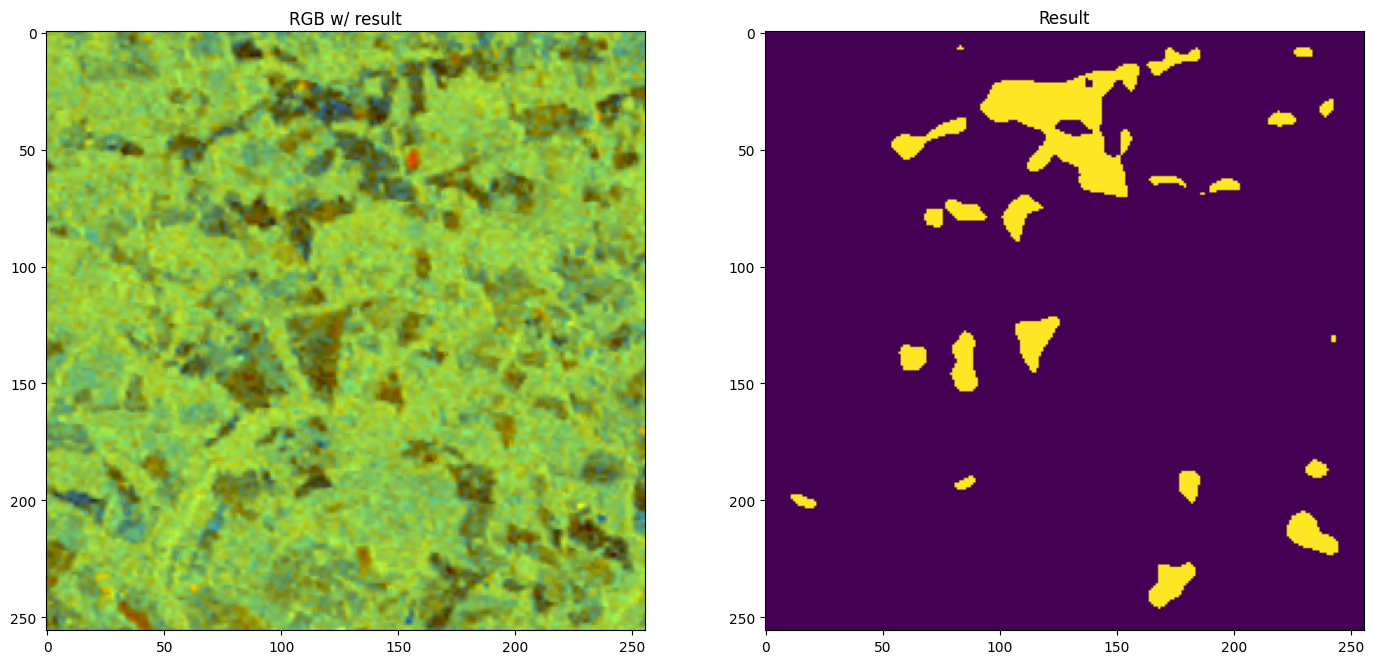

In [56]:
index = 395
visualize_result(val_df.iloc[index], final_predictions[index], figsize=(17,10))

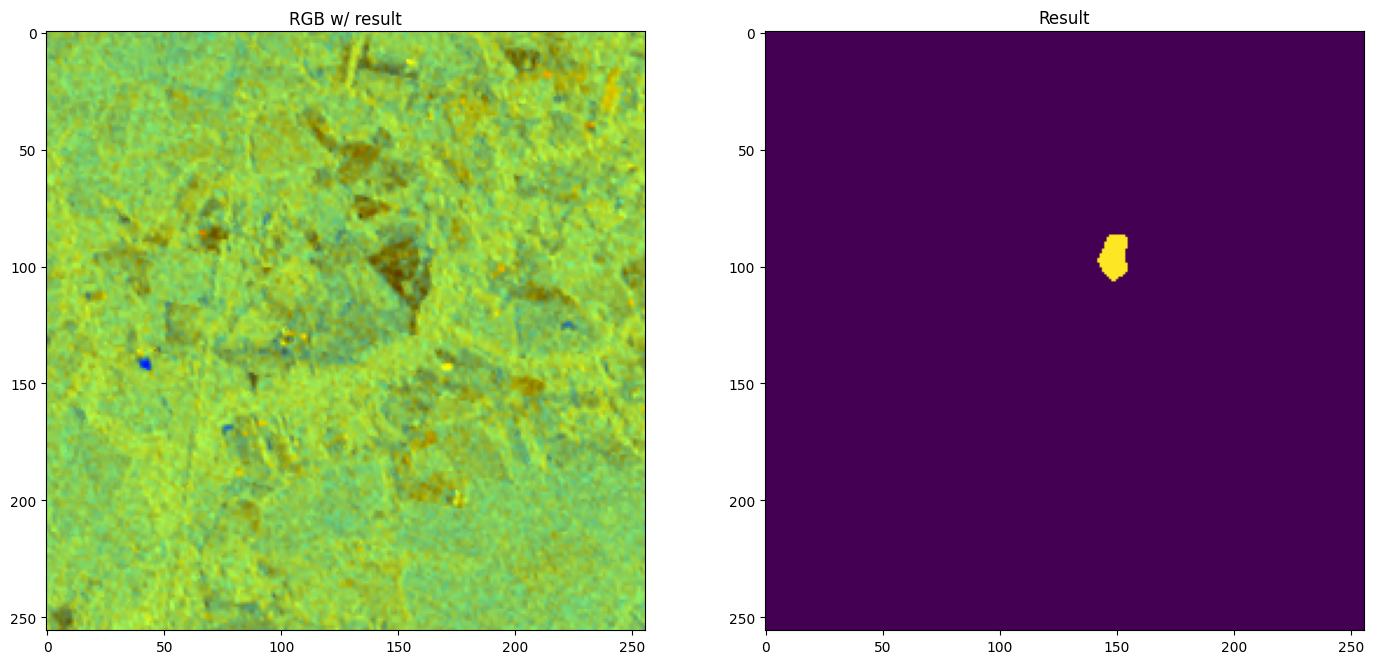

In [63]:
index = 4097
visualize_result(val_df.iloc[index], final_predictions[index], figsize=(17,10))

<ipython-input-14-2c3873e7741d>:2: RuntimeWarning: divide by zero encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)
<ipython-input-14-2c3873e7741d>:2: RuntimeWarning: invalid value encountered in divide
  ratio_image = np.clip(np.nan_to_num(vv_image/vh_image, 0), 0, 1)


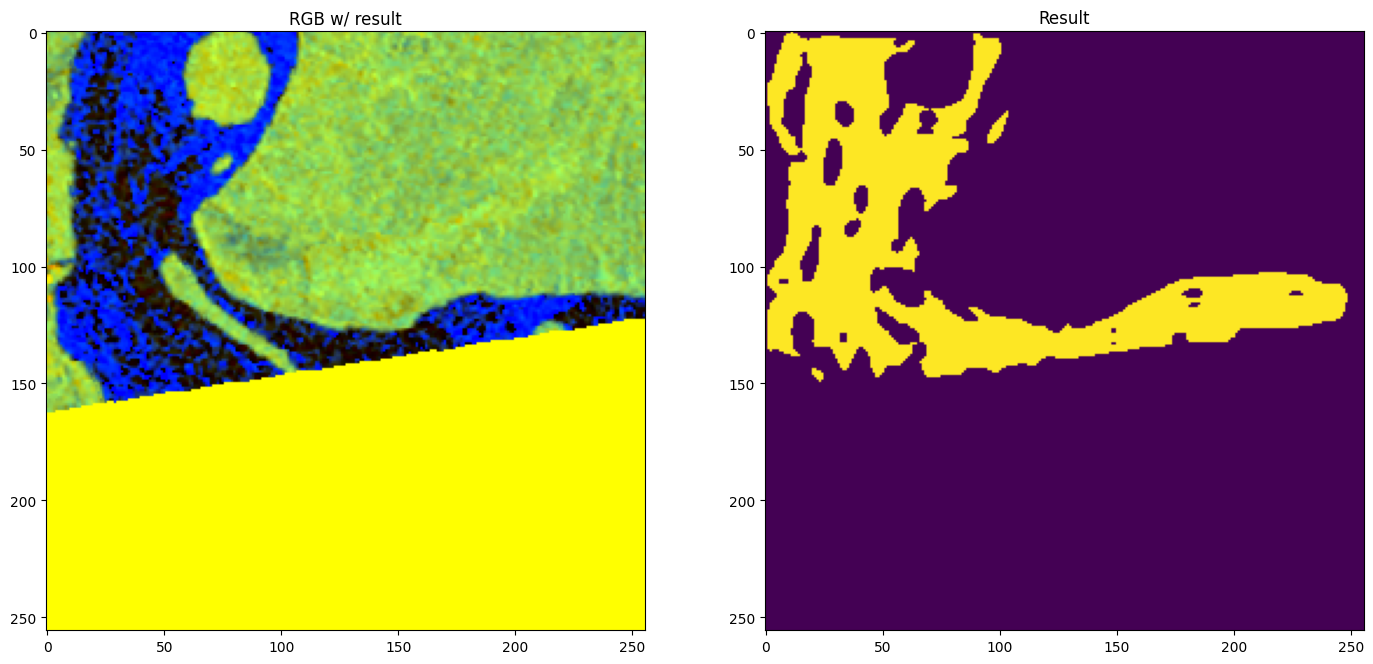

In [77]:
index = 8999
visualize_result(val_df.iloc[index], final_predictions[index], figsize=(17,10))